In [ ]:
import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import math
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import LSTM
from numpy import array
from tensorflow.keras.utils import plot_model

In [ ]:
df=pd.read_excel("/content/drive/MyDrive/Colab Notebooks/TSLA.xlsx",index_col=0,engine='openpyxl')

#some initial data preprocessing for right format
a="%Y-%m-%d %H:%M:%S"
df.time=pd.to_datetime(df.time,format=a,errors='coerce')
df=df[df['time'].notna()]
df=df[::-1].reset_index(drop=True)
df[["open","high","low","close","volume"]]=df[["open","high","low","close","volume"]].apply(pd.to_numeric)

In [ ]:
df

,time,open,high,low,close,volume
0,2020-08-28 04:05:00,451.9980,451.998,451.9980,451.998,2820
1,2020-08-28 04:10:00,452.0000,452.000,452.0000,452.000,1855
2,2020-08-28 04:25:00,453.5580,453.558,453.5580,453.558,1370
3,2020-08-28 04:35:00,454.0120,454.012,454.0000,454.000,3715
4,2020-08-28 04:50:00,453.6020,453.602,453.5400,453.540,2855
...,...,...,...,...,...,...
45006,2021-08-20 19:40:00,679.9999,680.000,679.9999,680.000,590
45007,2021-08-20 19:45:00,679.9000,679.900,679.8000,679.800,1444
45008,2021-08-20 19:50:00,679.9000,680.000,679.9000,680.000,1039
45009,2021-08-20 19:55:00,680.1000,680.200,680.1000,680.120,1247


In [ ]:
df.corr()

,open,high,low,close,volume
open,1.000000,0.999922,0.999932,0.999912,-0.137045
high,0.999922,1.000000,0.999845,0.999922,-0.131496
low,0.999932,0.999845,1.000000,0.999938,-0.142275
close,0.999912,0.999922,0.999938,1.000000,-0.136794
volume,-0.137045,-0.131496,-0.142275,-0.136794,1.000000


In [ ]:
df1=df.reset_index()['close']
df2=df.reset_index()['open']
df3=df.reset_index()['high']
df4=df.reset_index()['low']

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6b31c799a0>,
      dtype=object)

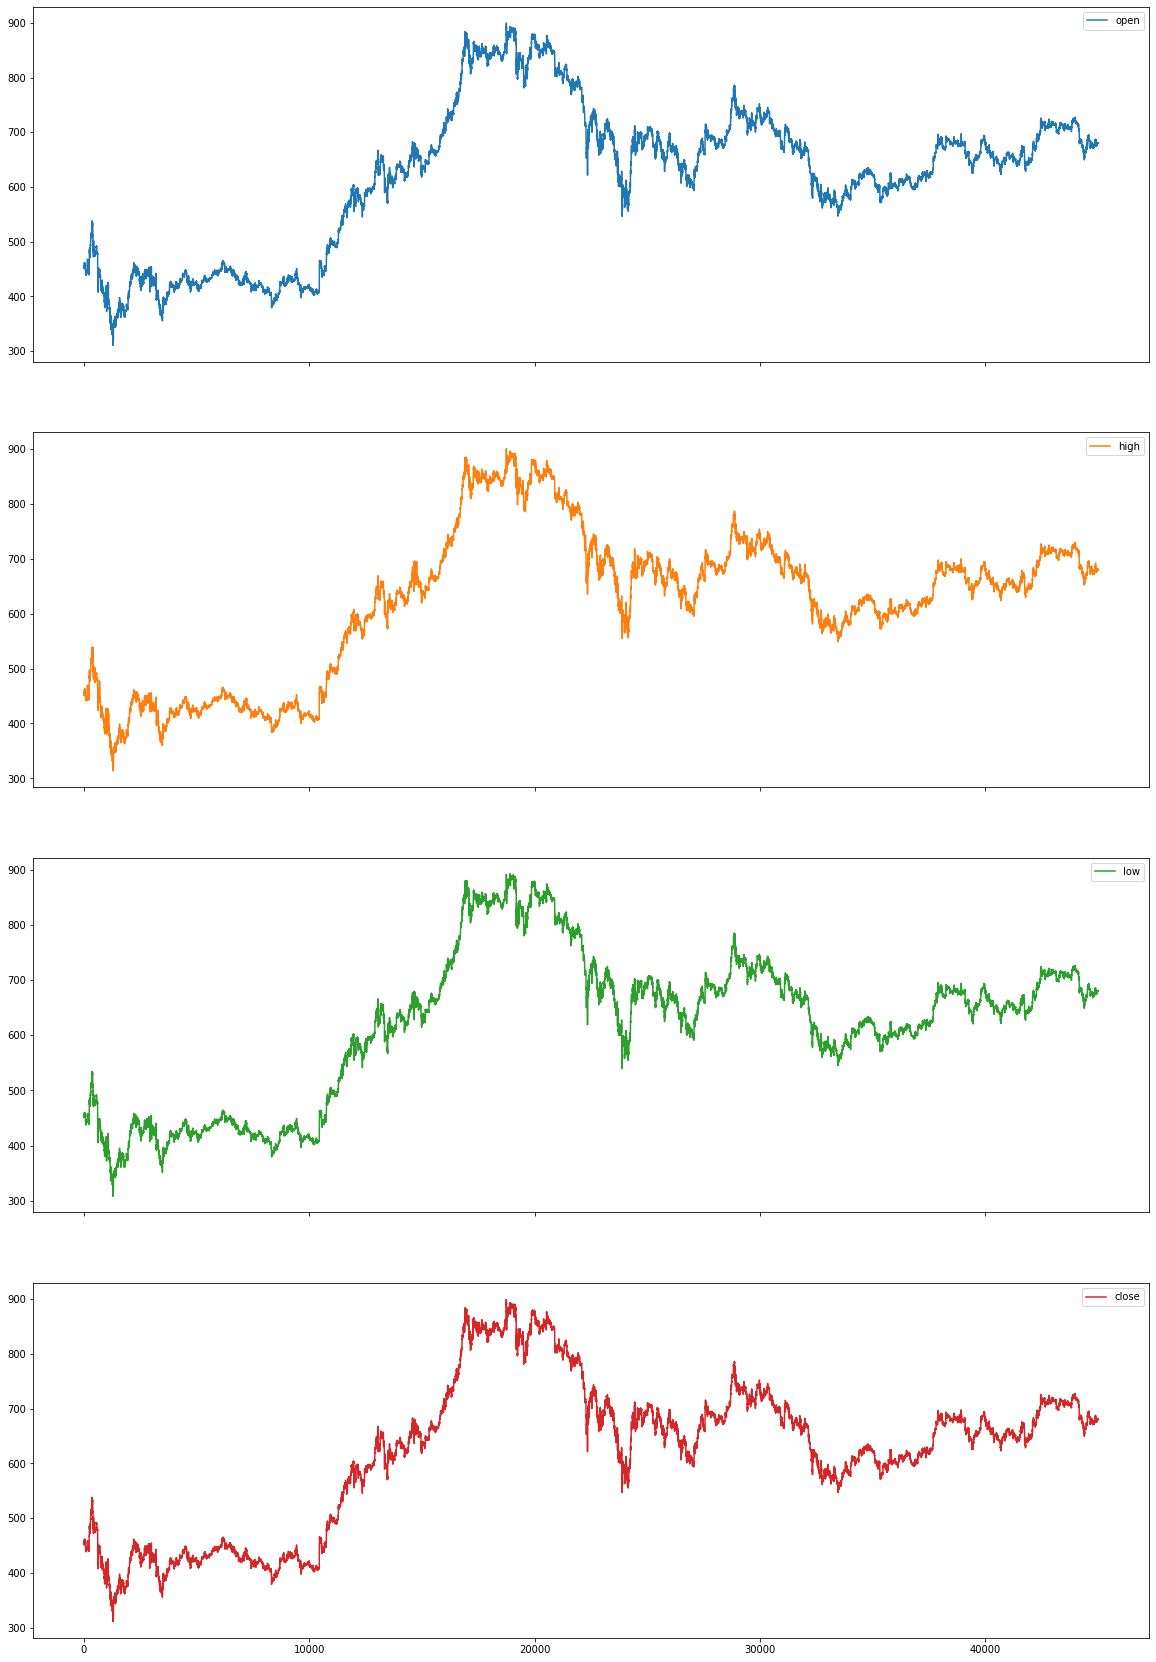

In [ ]:
data_df=df.reset_index().drop(columns=['index','volume','time'])
data_df.plot(subplots=True,figsize=(20,30))

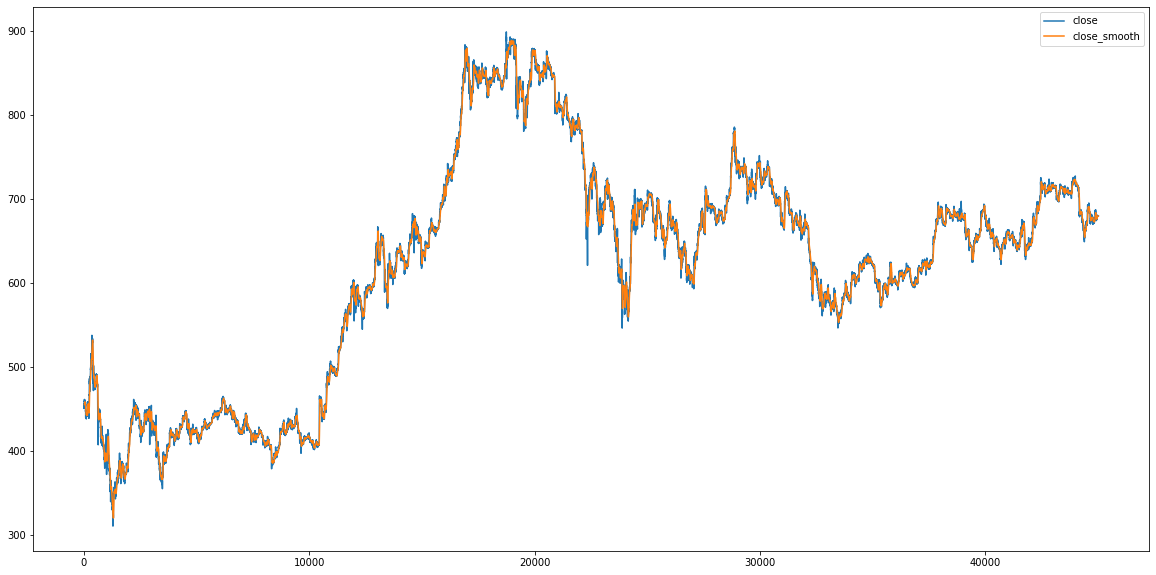

In [ ]:
#plotting the smoorth rolling mena
df1=pd.DataFrame(df1)
df1['close_smooth']=df1.rolling(30).mean()
df1.plot(figsize=(20,10))
plt.legend()

In [ ]:
df1=df1.reset_index()['close']
df1

0        451.998
1        452.000
2        453.558
3        454.000
4        453.540
          ...   
45006    680.000
45007    679.800
45008    680.000
45009    680.120
45010    680.300
Name: close, Length: 45011, dtype: float64

In [ ]:
data_df

,open,high,low,close
0,451.9980,451.998,451.9980,451.998
1,452.0000,452.000,452.0000,452.000
2,453.5580,453.558,453.5580,453.558
3,454.0120,454.012,454.0000,454.000
4,453.6020,453.602,453.5400,453.540
...,...,...,...,...
45006,679.9999,680.000,679.9999,680.000
45007,679.9000,679.900,679.8000,679.800
45008,679.9000,680.000,679.9000,680.000
45009,680.1000,680.200,680.1000,680.120


In [ ]:
#LSTM are sensitive to the scale of the data . so we applu MInMax scaler
scaler=MinMaxScaler(feature_range=(0,1))
df_data=scaler.fit_transform(np.array(data_df))

In [ ]:
df_data

array([[0.24015352, 0.23552638, 0.24640315, 0.23967427],
       [0.24015691, 0.23552979, 0.24640657, 0.23967767],
       [0.24280268, 0.238186  , 0.24907255, 0.24232602],
       ...,
       [0.62717261, 0.62424346, 0.63637919, 0.62724156],
       [0.62751225, 0.62458443, 0.63672142, 0.62744554],
       [0.62768207, 0.62475492, 0.63655031, 0.62775151]])

In [ ]:
?#splitting dataset into train and test split
training_size=int(len(df_data)*0.70)
test_size=len(df_data)-training_size
train_data,test_data=df_data[0:training_size,:],df_data[training_size:len(df_data),:]  #: means columns arenot split

Object `#splitting dataset into train and test split` not found.


In [ ]:
# train_data,test_data=df1[:int(len(df1)*0.7)],df1[int(len(df1)*0.7):]
# plt.figure(figsize=(20,10))
# plt.grid(True)
# plt.xlabel('Dates')
# plt.ylabel('CLosing prices')
# plt.plot(train_data,'green',label='training data')
# plt.plot(test_data,'blue',label='test data')
# plt.legend()

In [ ]:
def create_dataset(dataset,time_step=1):
  dataX,dataY=[],[]
  for i in range(len(dataset)-time_step-1):
    a=dataset[i:(i+time_step)]
    dataX.append(a)
    dataY.append(dataset[i+time_step,3])
  return np.array(dataX),np.array(dataY)

In [ ]:
#reshape into X=t,t+1.t+2,t+3 and Y=t+4
time_step=100
X_train,y_train=create_dataset(train_data,time_step)
X_test,y_test=create_dataset(test_data,time_step)

In [ ]:
print(X_test.shape)
print(y_test.shape)

(13403, 100, 4)
(13403,)


In [ ]:
X_test

array([[[0.60220933, 0.60277896, 0.61007016, 0.60284033],
        [0.60249803, 0.60086932, 0.60968515, 0.60342933],
        [0.60363581, 0.60264257, 0.61071184, 0.60562416],
        ...,
        [0.63294643, 0.63038104, 0.63997262, 0.6321711 ],
        [0.6317577 , 0.62867616, 0.6369781 , 0.62766652],
        [0.62797076, 0.62748274, 0.63718344, 0.63021628]],

       [[0.60249803, 0.60086932, 0.60968515, 0.60342933],
        [0.60363581, 0.60264257, 0.61071184, 0.60562416],
        [0.60582646, 0.60540448, 0.61394593, 0.60821251],
        ...,
        [0.6317577 , 0.62867616, 0.6369781 , 0.62766652],
        [0.62797076, 0.62748274, 0.63718344, 0.63021628],
        [0.62904061, 0.62678374, 0.63689254, 0.62766652]],

       [[0.60363581, 0.60264257, 0.61071184, 0.60562416],
        [0.60582646, 0.60540448, 0.61394593, 0.60821251],
        [0.60857735, 0.60562612, 0.61370637, 0.60514362],
        ...,
        [0.62797076, 0.62748274, 0.63718344, 0.63021628],
        [0.62904061, 0.626783

In [ ]:
y_test

array([0.62766652, 0.62708857, 0.62975733, ..., 0.62690159, 0.62724156,
       0.62744554])

In [ ]:
#Create the stacked LSTM model
model=Sequential()
model.add(LSTM(512,activation='relu',return_sequences=True,input_shape=(100,4)))
#model.addDropout(0.3)
model.add(LSTM(256,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss="mean_squared_error",optimizer='adam' ,metrics=['acc'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 512)          1058816   
                                                                 
 lstm_1 (LSTM)               (None, 256)               787456    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 1,846,529
Trainable params: 1,846,529
Non-trainable params: 0
_________________________________________________________________


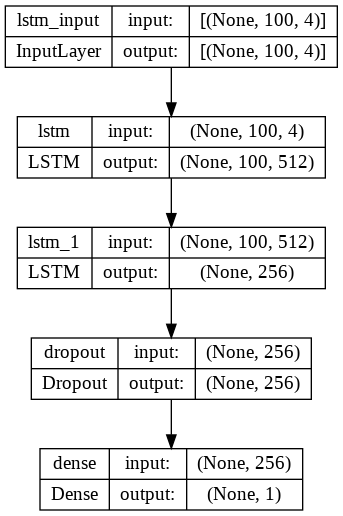

In [ ]:
plot_model(model,to_file='timeseriesmodel.png',show_shapes=True,show_layer_names=True   )

In [ ]:
r=model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=1,batch_size=64,verbose=1)

491/491 [==============================] - 179s 356ms/step - loss: 0.0046 - acc: 6.3682e-05 - val_loss: 2.6069e-05 - val_acc: 0.0000e+00


In [ ]:
#prediction and cgeck performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

419/419 [==============================] - 13s 30ms/step


In [ ]:
#make readt prediction for inverse scalar transform
train_predict=np.repeat(train_predict,X_train.shape[2],axis=-1)
test_predict=np.repeat(test_predict,X_test.shape[2],axis=-1)

In [ ]:
#transform back to original form
train_predict=scaler.inverse_transform(train_predict)[:,0]
test_predict=scaler.inverse_transform(test_predict)[:,0]


In [ ]:
train_predict

array([442.5207, 442.456 , 442.3175, ..., 665.7882, 665.9455, 665.9941],
      dtype=float32)

In [ ]:
#Test Data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

646.4624213141833

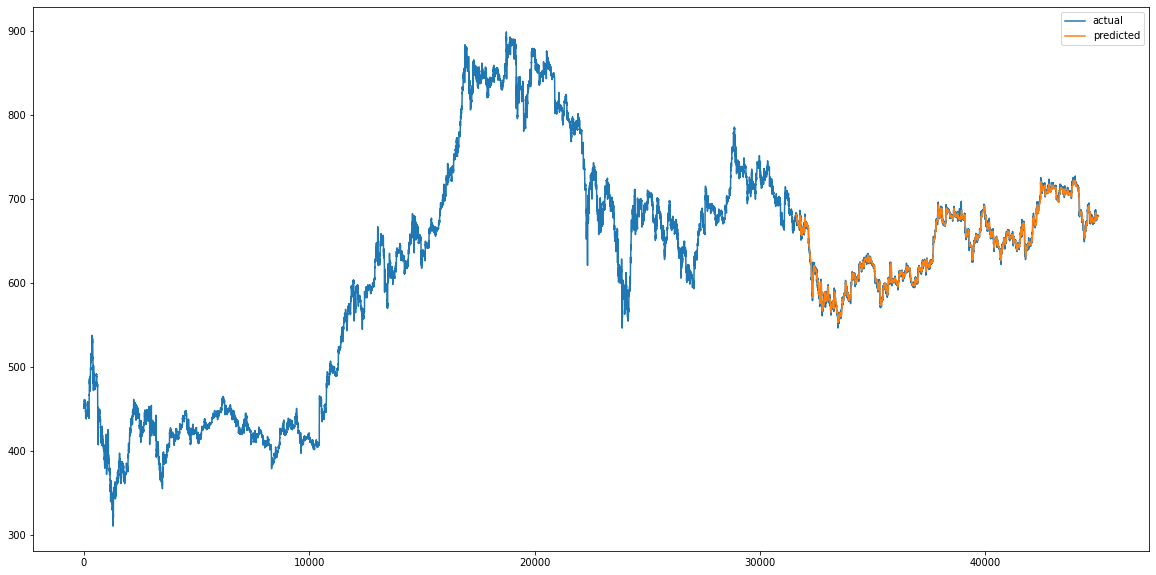

In [ ]:
#plotting
#shift train predictions for plotting
look_back=100
trainPredictionPlot=np.empty_like(data_df['close'])
trainPredictionPlot[:]=np.nan
trainPredictionPlot[look_back:len(train_predict)+look_back]=train_predict

#shift test predictions for plotting

trainPredictionPlot=np.empty_like(df1)
trainPredictionPlot[:]=np.nan
trainPredictionPlot[len(train_predict)+(look_back*2)+1:len(df1)-1]=test_predict
#plot baseline and predictions
plt.figure(figsize=(20,10))

plt.plot(data_df['close'],label='actual')
plt.plot(trainPredictionPlot,label='predicted')
plt.legend()
plt.show()